In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import cellcharter as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import scvi
import squidpy as sq
import scanpy as sc
from matplotlib import cm

 captum (see https://github.com/pytorch/captum).
Global seed set to 0


In [3]:
PALETTE_STEP = {
    'Dimensionality reduction': "#21409A",
    'Spatial embedding': "#006838",
    'Clustering': "#C2B59B"
}

In [4]:
times_cpu = pd.read_csv('results/merscope_human_lung_cancer/time_merscope_human_lung_cancer_CellCharter_k29_cpu.csv', index_col=0)
times_gpu = pd.read_csv('results/merscope_human_lung_cancer/time_merscope_human_lung_cancer_CellCharter_k29_gpu.csv', index_col=0)

In [5]:
times_cpu.index = ['CellCharter (CPU)']
times_gpu.index = ['CellCharter (GPU)']
times = pd.concat([times_cpu, times_gpu], axis=0)
times /= 60

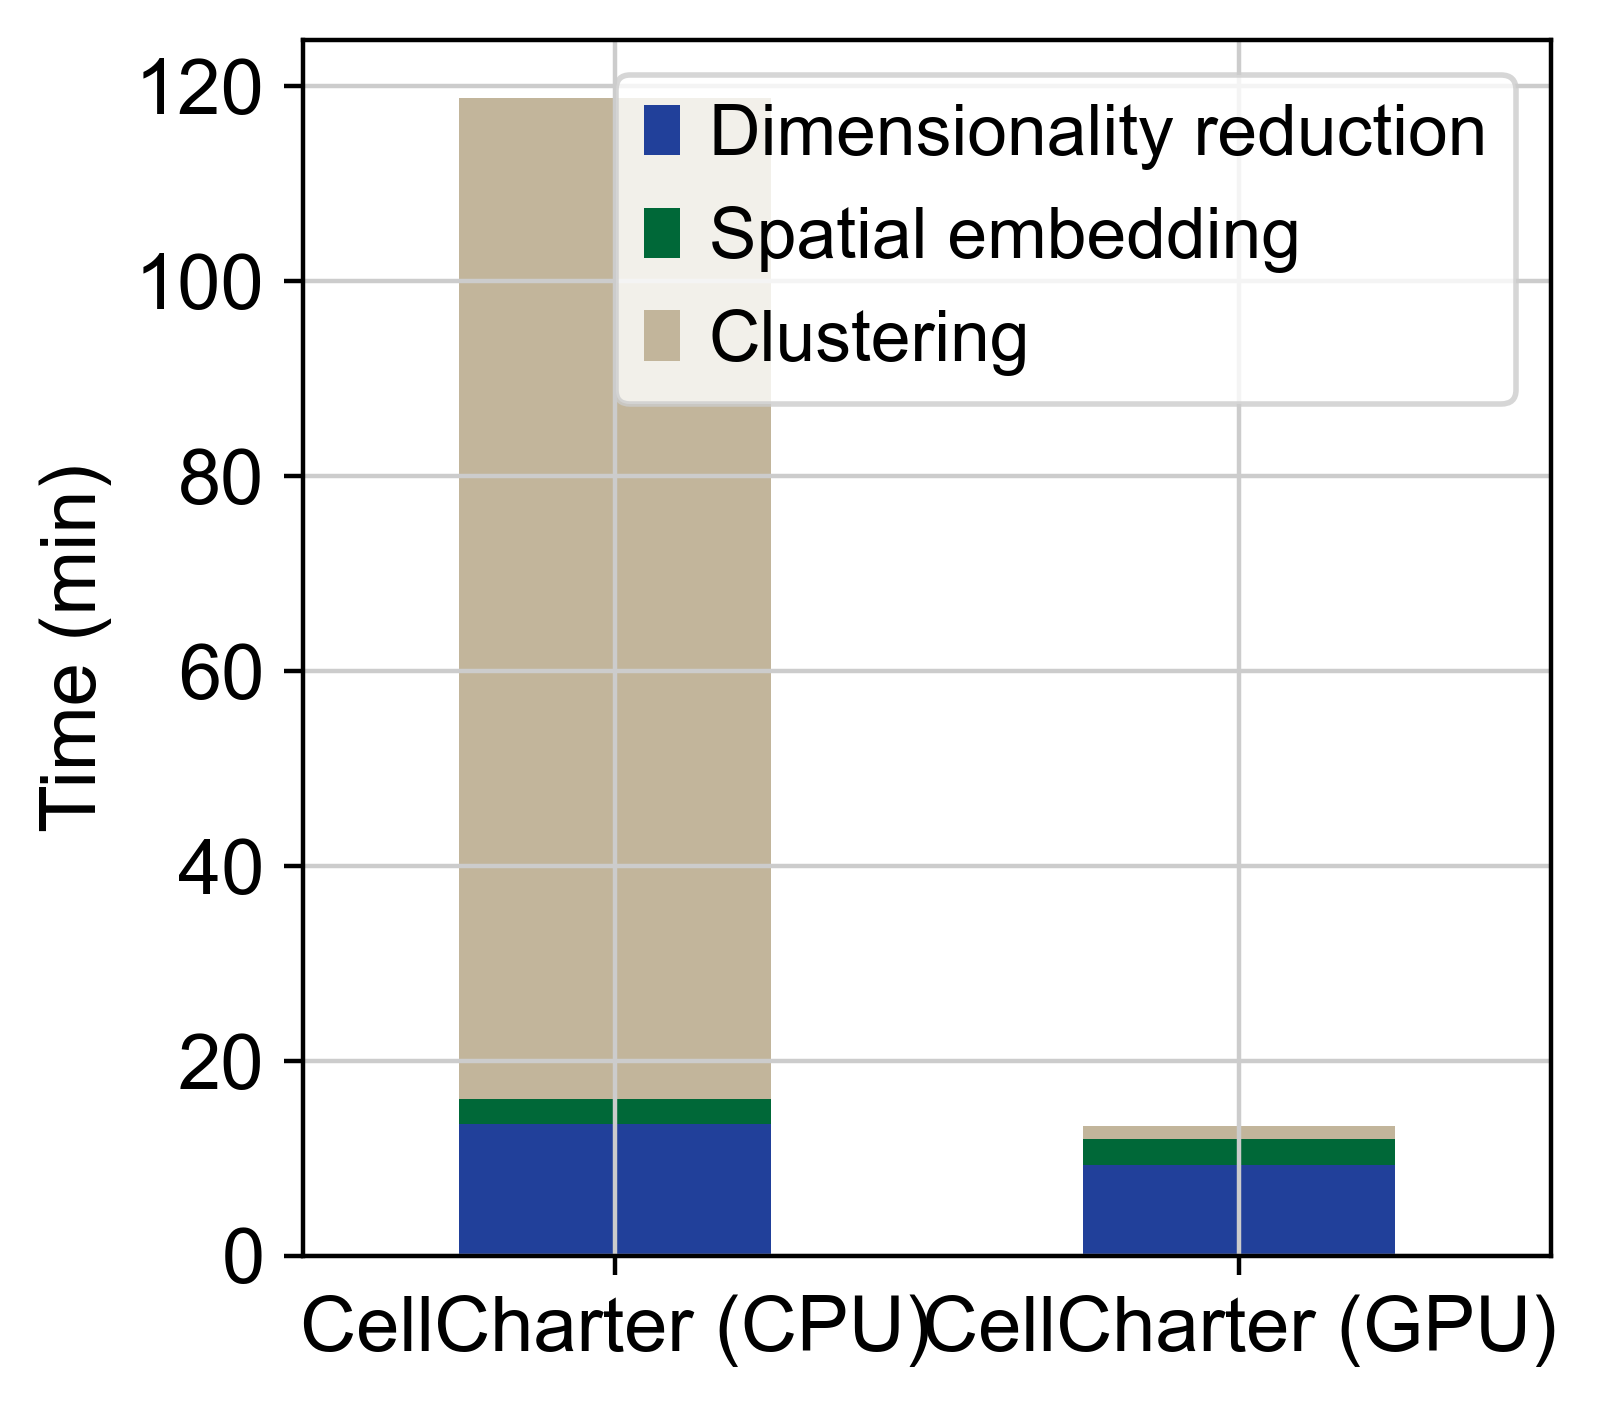

In [6]:
times.loc[['CellCharter (CPU)', 'CellCharter (GPU)'], ['Dimensionality reduction', 'Spatial embedding', 'Clustering']].plot.bar(stacked=True, color=PALETTE_STEP)
plt.ylabel('Time (min)')
plt.xticks(rotation=0)
plt.show()

In [7]:
adata = ad.read_h5ad('data/merscope_human_lung_cancer/merscope_human_lung_cancer_nhood3.h5ad')

In [8]:
adata.uns[f'cluster_cellcharter_colors_map'] = {
    0: cm.get_cmap('tab20')(2),
    1: cm.get_cmap('tab20')(17),
    2: cm.get_cmap('tab20')(16),
    3: cm.get_cmap('tab20')(14),
    4: cm.get_cmap('tab20')(18),
    5: cm.get_cmap('tab20')(12),
    6: cm.get_cmap('tab20')(4),
    7: cm.get_cmap('tab20')(15),
    8: cm.get_cmap('tab20')(1),
    9: cm.get_cmap('tab20')(3),
    10: cm.get_cmap('tab20')(0),
    11: cm.get_cmap('tab20')(9),
    12: cm.get_cmap('tab20')(6),
    13: cm.get_cmap('tab20')(7),
    14: cm.get_cmap('tab20')(5),
    15: cm.get_cmap('tab20')(10),
    16: cm.get_cmap('tab20')(13),
    17: cm.get_cmap('tab20')(19),
    18: cm.get_cmap('tab20')(8),
    19: cm.get_cmap('tab20')(11),
}
adata.uns[f'cluster_cellcharter_colors'] = [adata.uns[f'cluster_cellcharter_colors_map'][cluster] for cluster in adata.obs['cluster_cellcharter'].cat.categories]
del adata.uns[f'cluster_cellcharter_colors_map']

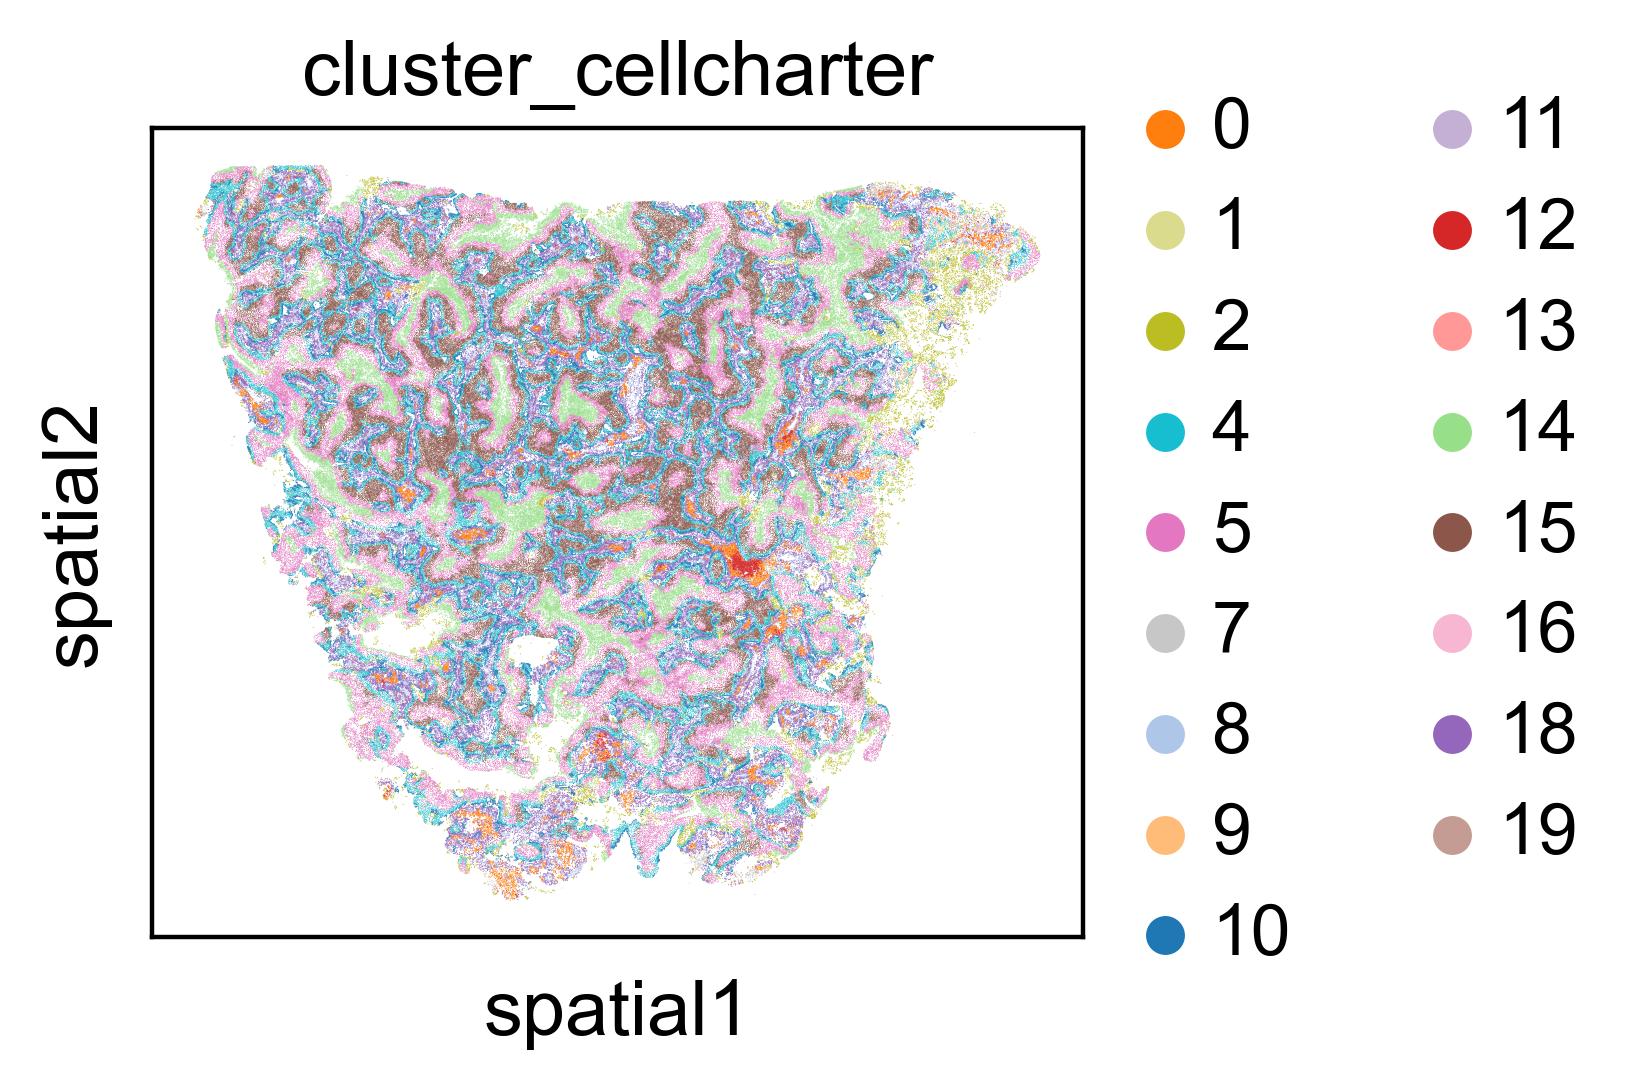

In [9]:
sq.pl.spatial_scatter(
    adata,
    color='cluster_cellcharter',
    img=None,
    size=5,
    library_key='sample',
    library_id='HumanLungCancerPatient1',
)

In [10]:
model = scvi.model.SCANVI.load('data/merscope_human_lung_cancer/merscope_human_lung_cancer_scanvi_model', adata=adata)

INFO     File data/merscope_human_lung_cancer/merscope_human_lung_cancer_scanvi_model/model.pt already downloaded  


In [11]:
adata.obs['C_scANVI'] = model.predict(adata)
adata.obs.loc[adata.obs['C_scANVI'].isin(['Mast cell', 'transitional club/AT2', 'Alveolar cell type 1', 'Club', 'Ciliated', 'cDC1']), 'C_scANVI'] = 'Tumor cells'
adata.obs.loc[adata.obs['C_scANVI'] == 'Alveolar cell type 2', 'C_scANVI'] = 'other'
adata.obs['C_scANVI'] = adata.obs['C_scANVI'].astype('category')

In [12]:
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}

In [13]:
signatures = pd.read_excel('data/tumor_cell_state_signatures_gavish.xlsx')
signatures.columns = [c.replace('/', '').replace('  ', '_').replace(' - ', '-').replace(' ', '_') for c in signatures.columns]
signatures_dict = signatures.to_dict(orient='list')

signatures_dict['Cell_Proliferation'] = [x for x in pd.concat((
        signatures['MP1_Cell_Cycle-G2M'],
        signatures['MP2_Cell_Cycle-G1S'],
        signatures['MP3_Cell_Cylce_HMG-rich'],
        signatures['MP4_Cell_Cylce_Chromatin_']
    ))
               if x in adata.var_names]

In [14]:
def score_cells(adata, signature_name, genes):
    adata.obs[f'score_{signature_name}'] = np.nan
    for patient in adata.obs['sample'].cat.categories:
        adata_patient = adata[adata.obs['sample'] == patient].copy()
        sc.tl.score_genes(adata_patient, gene_list=[x for x in genes if x in adata_patient.var_names], score_name=f'score_{signature_name}')
        adata.obs[f'score_{signature_name}'][adata.obs['sample'] == patient] = adata_patient.obs[f'score_{signature_name}']

In [15]:
def smooth_signature(adata, signature_name, n_neighbors, group_key=None, groups=None):
    if groups:
        adata_groups = adata[adata.obs[group_key].isin(groups)]
    sq.gr.spatial_neighbors(adata_groups, library_key='sample', n_neighs=n_neighbors, coord_type='generic')
    adata_groups.obsp['spatial_connectivities'].setdiag(1)
    
    adata.obs[f'score_{signature_name}_smoothed'] = np.nan
    for sample in adata_groups.obs['sample'].cat.categories:
        adata_groups_sample = adata_groups[adata_groups.obs['sample'] == sample]
        adata_groups_sample.obs[f'score_{signature_name}_smoothed'] = np.nan*np.ones(adata_groups_sample.shape[0])
        adj = adata_groups_sample.obsp['spatial_connectivities']
        score_smoothed = (adj @ adata_groups_sample.obs[f'score_{signature_name}']) / np.array(np.sum(adj, axis=1)).squeeze()
        score_smoothed[score_smoothed == float('inf')] = 0

        low = np.nanpercentile(score_smoothed, 5)
        score_smoothed[score_smoothed < low] = low

        high = np.nanpercentile(score_smoothed, 95)
        score_smoothed[score_smoothed > high] = high

        adata.obs[f'score_{signature_name}_smoothed'][(adata.obs['sample'] == sample) & (adata.obs[group_key].isin(groups))] = score_smoothed
    

In [16]:
signatures_names  = ['MP6_Hypoxia', 'Cell_Proliferation']

In [17]:
for SIGNATURE_NAME in signatures_names:
    score_cells(adata, SIGNATURE_NAME, signatures_dict[SIGNATURE_NAME])
    smooth_signature(adata, SIGNATURE_NAME, 50, 'C_scANVI', ['Tumor cells'])

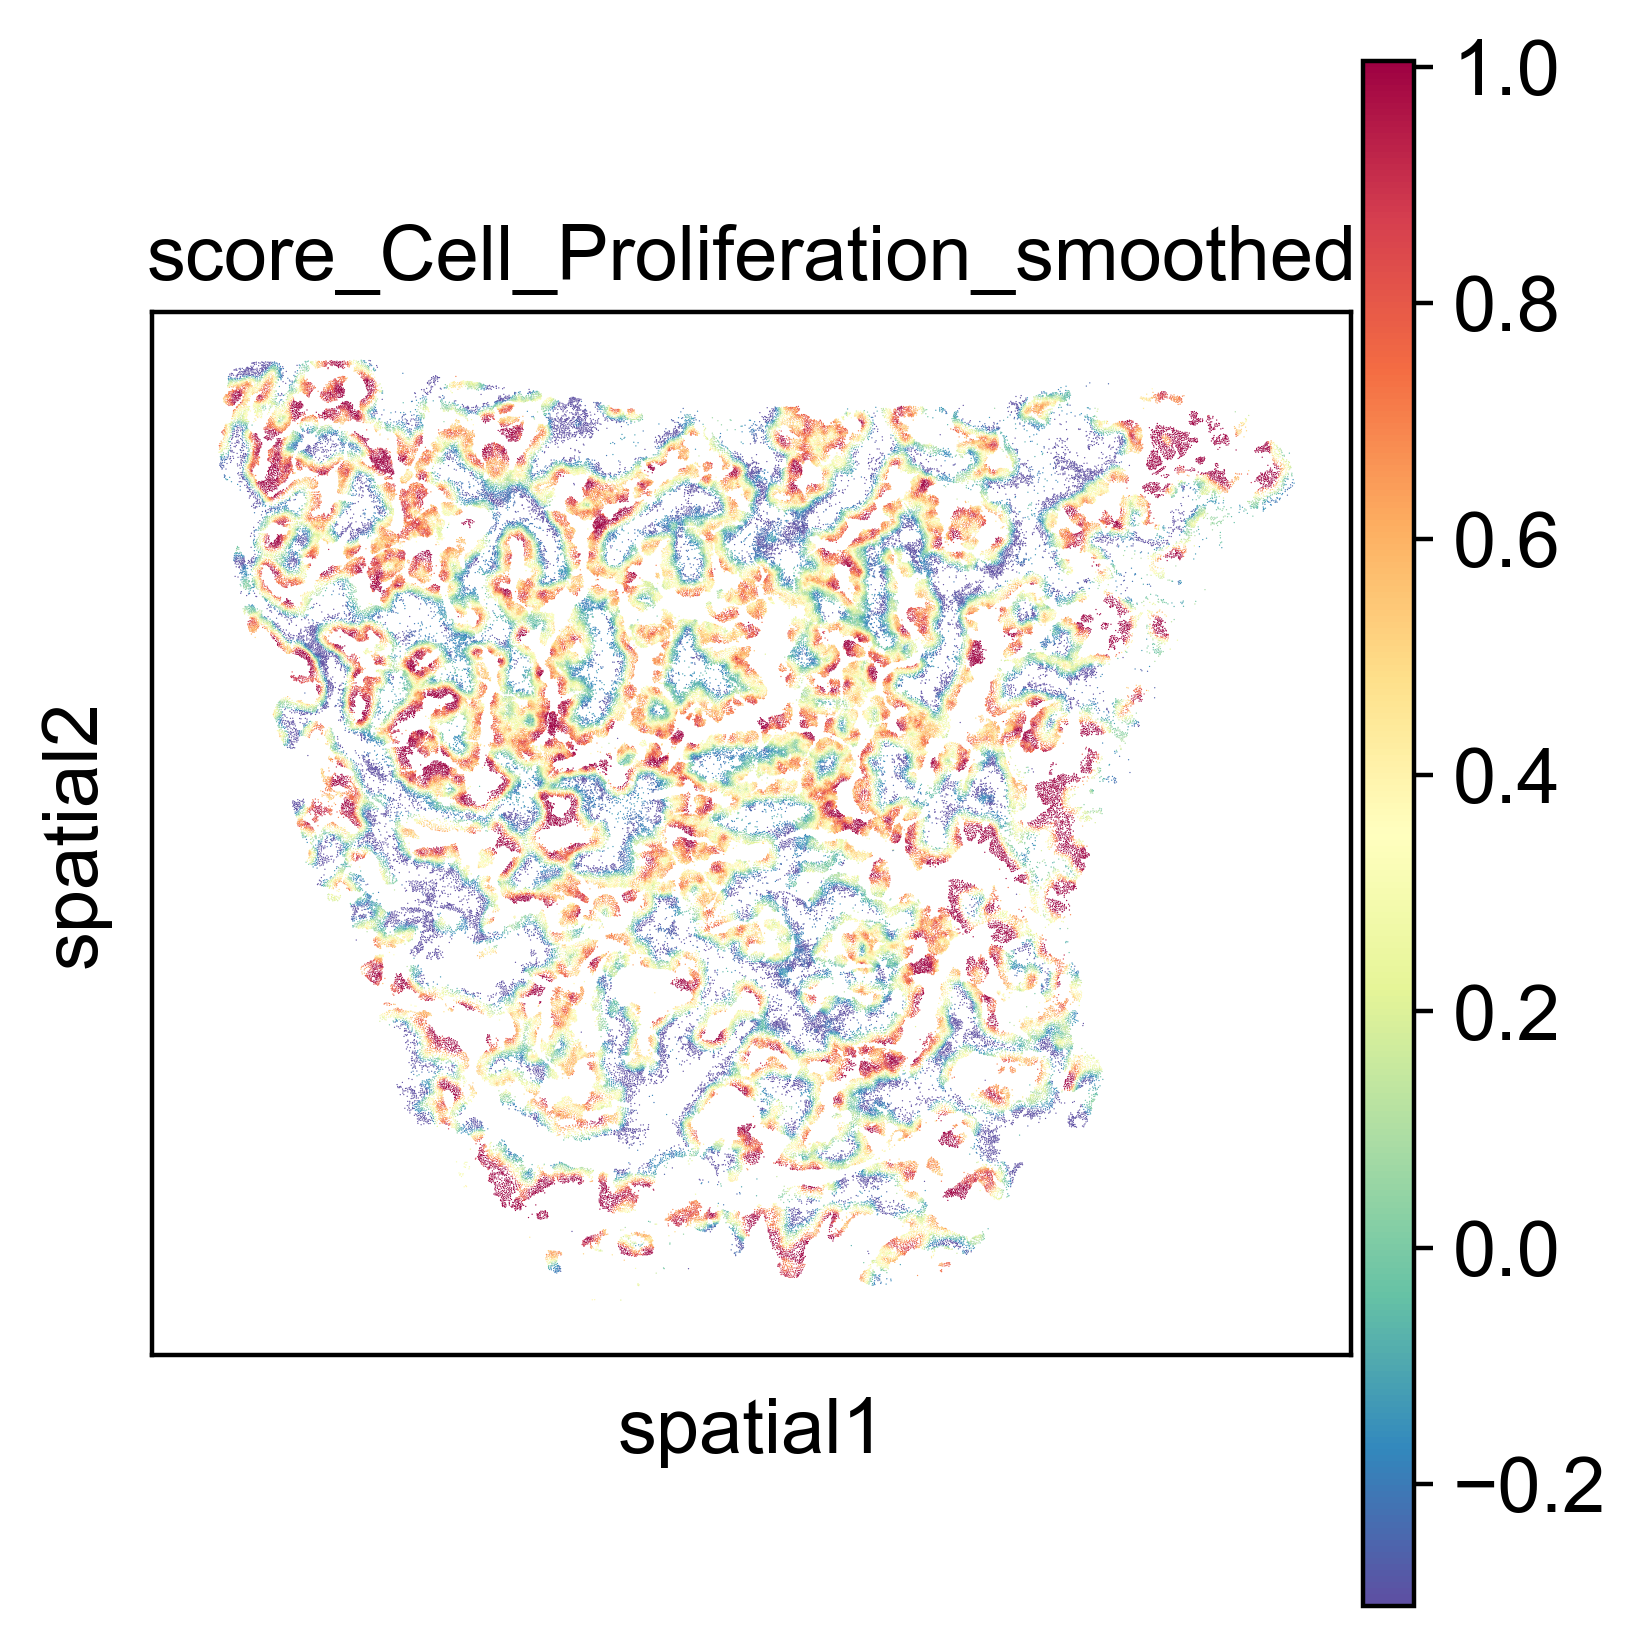

In [18]:
sq.pl.spatial_scatter(
    adata,
    color='score_Cell_Proliferation_smoothed',
    img=None,
    size=5,
    library_key='sample',
    library_id='HumanLungCancerPatient1',
    cmap='Spectral_r',
)

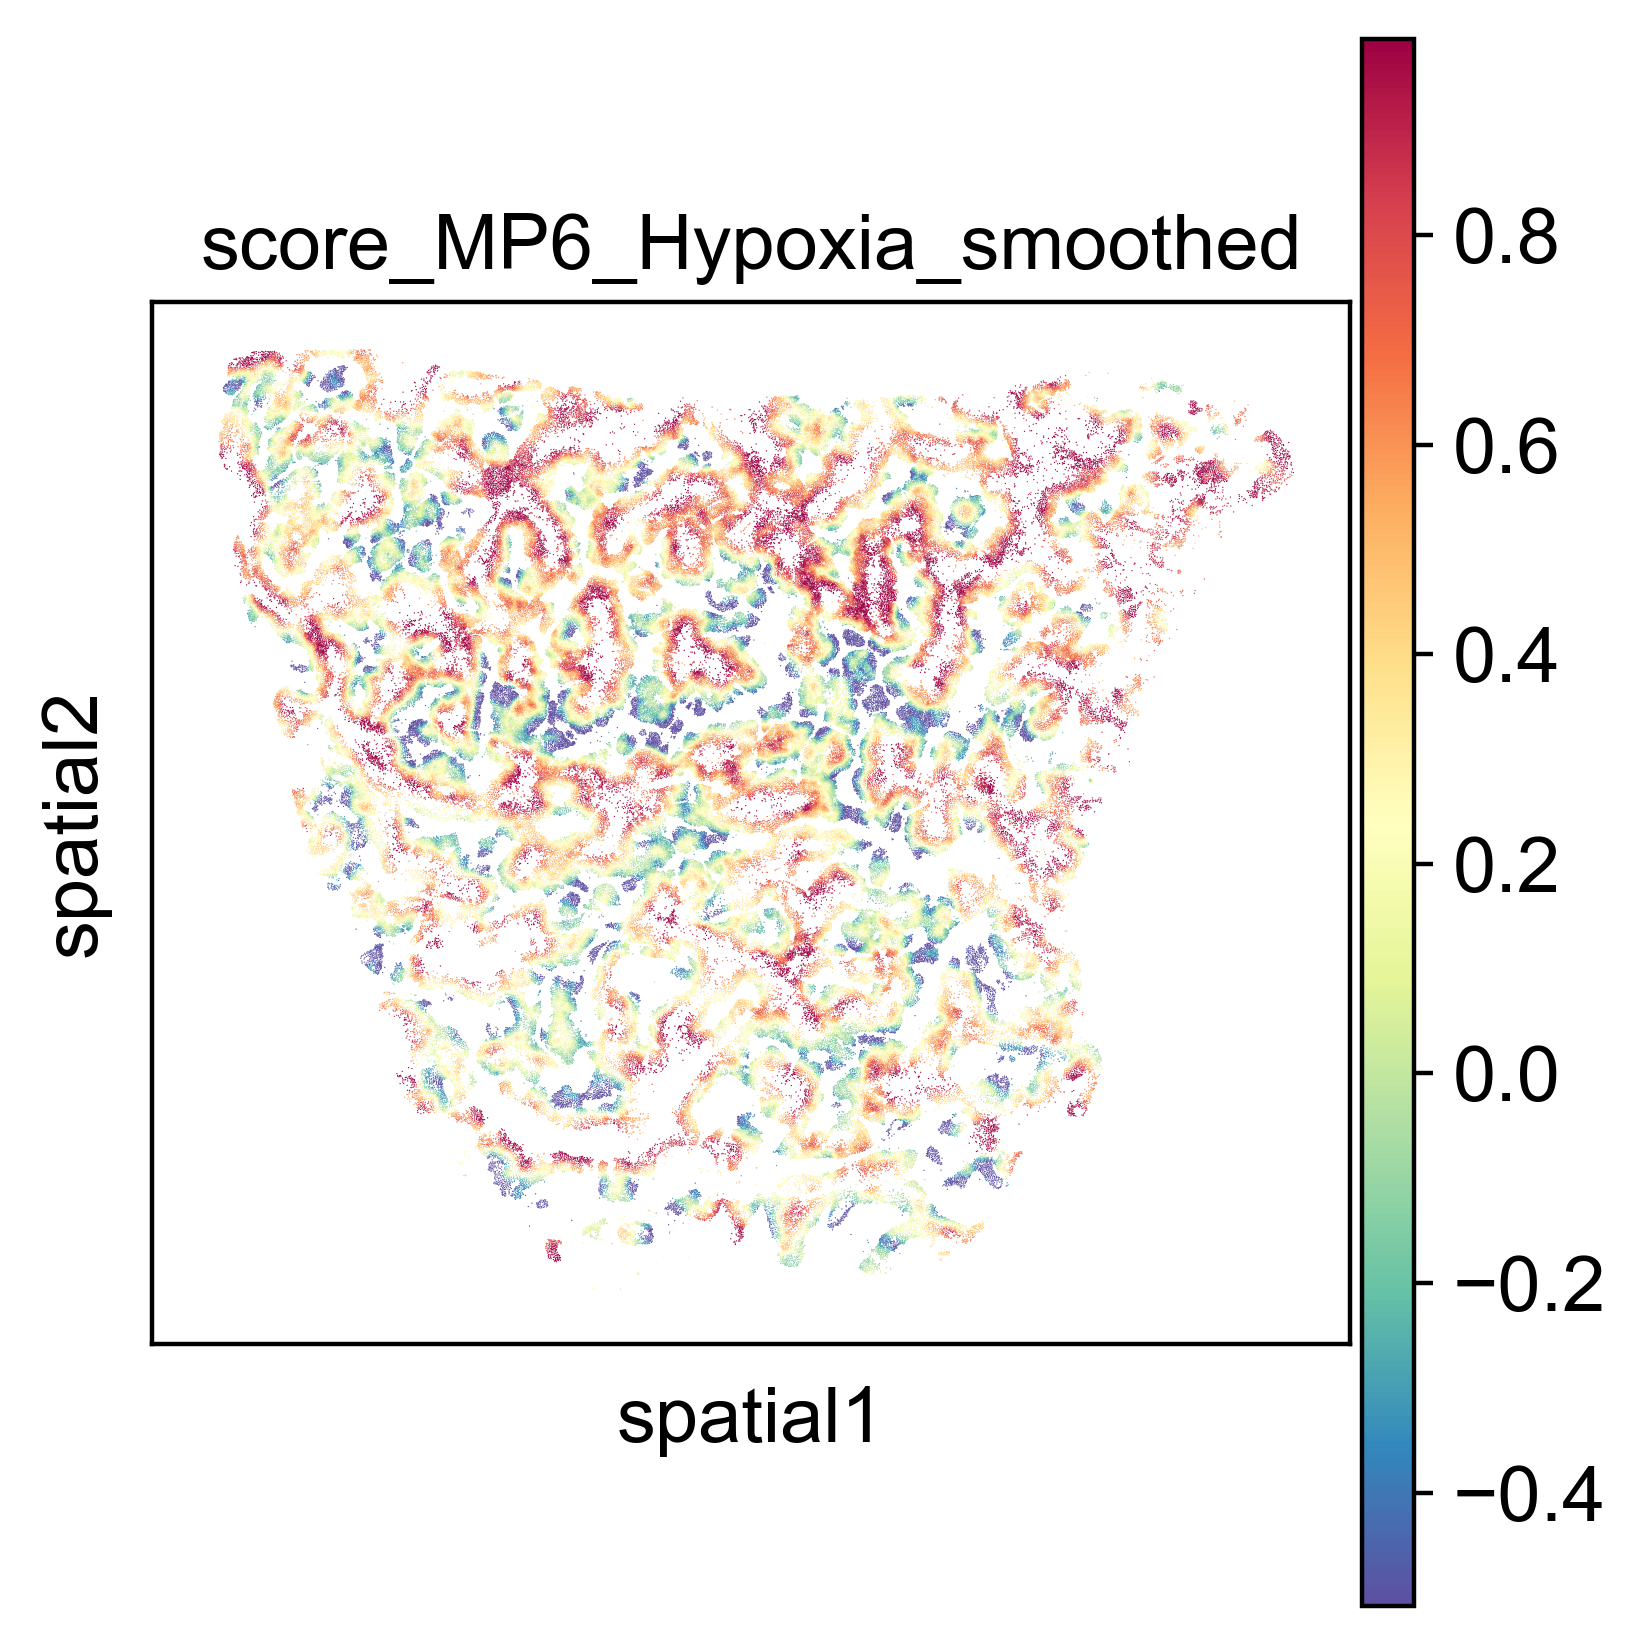

In [19]:
sq.pl.spatial_scatter(
    adata,
    color='score_MP6_Hypoxia_smoothed',
    img=None,
    size=5,
    library_key='sample',
    library_id='HumanLungCancerPatient1',
    cmap='Spectral_r',
)